In [1]:
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import log_loss
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

df = pd.read_csv("processed/11.csv")
df.head()

,card_id,day_offset,rating,state,duration,elapsed_days,elapsed_seconds,user_id,review_th,i,delta_t_f,t_bin,t_history,r_history,t_f_history,y
0,0,1430,1,0,120000,-1,-1,11,15024,1,-1.00s,1.00,NaN,NaN,NaN,0
1,0,1430,2,1,120000,0,461,11,15026,2,7.68min,426.88,-1,1,-1.00s,1
2,0,1430,3,1,49237,0,714,11,15029,3,11.90min,597.63,"-1,461","1,2","-1.00s,7.68min",1
3,1,1430,1,0,120000,-1,-1,11,15028,1,-1.00s,1.00,NaN,NaN,NaN,0
4,1,1430,3,1,25441,0,195,11,15031,2,3.25min,155.57,-1,1,-1.00s,1


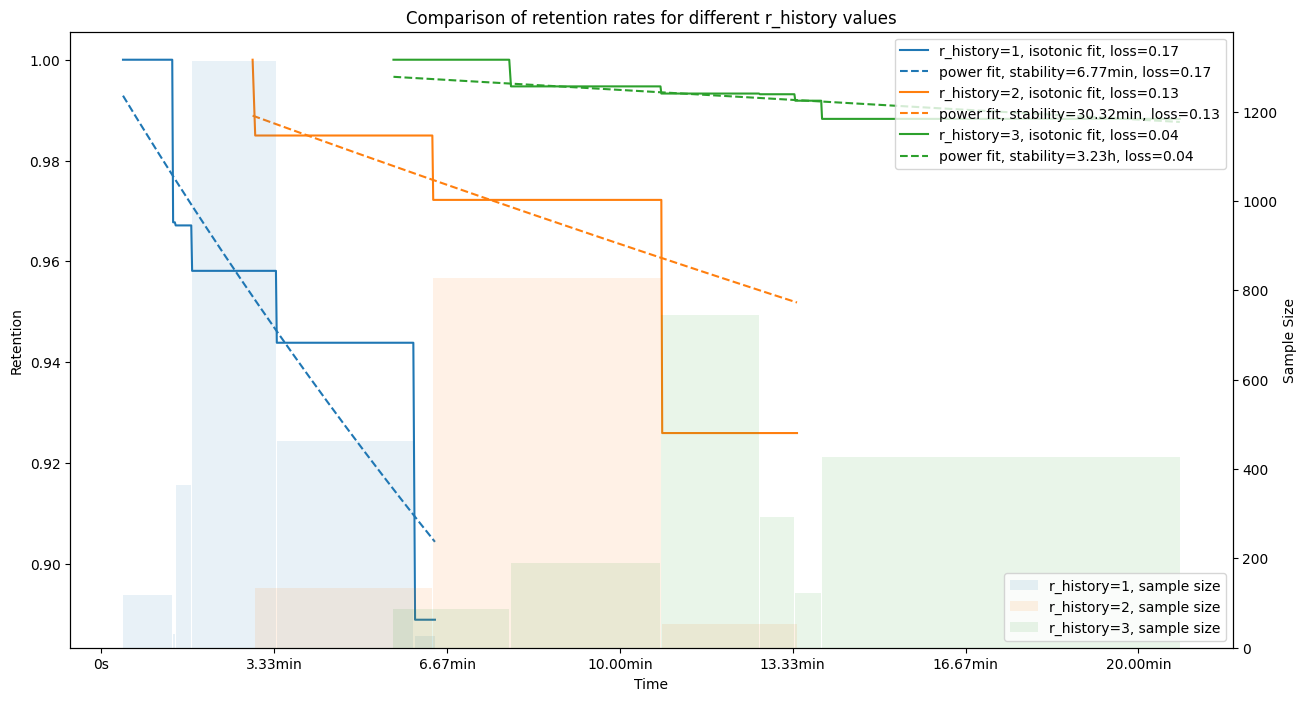

In [2]:
DECAY = -0.5


def power_forgetting_curve(t, s, decay=DECAY):
    factor = 0.9 ** (1 / decay) - 1
    return (1 + factor * t / s) ** decay


def fit_stability(delta_t, retention, size, decay=DECAY):

    def loss(stability):
        y_pred = power_forgetting_curve(delta_t, stability, decay)
        loss = sum(
            -(retention * np.log(y_pred) + (1 - retention) * np.log(1 - y_pred)) * size
        )
        return loss

    res = minimize(loss, x0=1, bounds=[(0.1, None)])
    return res.x[0]


fig, ax1 = plt.subplots(figsize=(15, 8))
ax2 = ax1.twinx()

for i, r_history in enumerate(("1", "2", "3")):
    color = f"C{i}"
    data = df[df["r_history"] == r_history][["elapsed_seconds", "y"]]
    Q1 = data["elapsed_seconds"].quantile(0.25)
    Q3 = data["elapsed_seconds"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_data = data[
        (data["elapsed_seconds"] >= lower_bound) & (data["elapsed_seconds"] <= upper_bound)
    ]
    x, y = filtered_data.sort_values(by="elapsed_seconds").values.T

    if all(y == 1):
        continue

    ir = IsotonicRegression(y_min=0, y_max=1, increasing=False)
    ir.fit(x, y)

    y_ir = ir.predict(x)
    loss_ir = log_loss(y, y_ir)

    s_seconds = fit_stability(x, y_ir, np.ones_like(x))
    s = (
        f"{s_seconds:.2f}s"
        if s_seconds < 60
        else (
            f"{s_seconds/60:.2f}min"
            if s_seconds < 3600
            else (
                f"{s_seconds/3600:.2f}h"
                if s_seconds < 86400
                else f"{s_seconds/86400:.2f}d"
            )
        )
    )
    y_pred = power_forgetting_curve(x, s_seconds)
    loss = log_loss(y, y_pred)
    cnt = len(x)

    ax1.plot(
        x,
        y_ir,
        "-",
        color=color,
        label=f"r_history={r_history}, isotonic fit, loss={loss_ir:.2f}",
    )
    ax1.plot(
        x, y_pred, "--", color=color, label=f"power fit, stability={s}, loss={loss:.2f}"
    )

    unique_y_ir = np.unique(y_ir)
    segment_counts = []
    segment_x = []
    segment_widths = []
    for i in range(len(unique_y_ir)):
        mask = y_ir == unique_y_ir[i]
        segment_counts.append(np.sum(mask))
        segment_x.append(np.min(x[mask]))
        segment_widths.append(np.max(x[mask]) - np.min(x[mask]))

    ax2.bar(
        segment_x,
        segment_counts,
        alpha=0.1,
        width=segment_widths,
        color=color,
        label=f"r_history={r_history}, sample size",
        align="edge",
    )

ax1.set_title(f"Comparison of retention rates for different r_history values")
ax1.legend(loc="upper right")
ax2.legend(loc="lower right")


def format_time(x, pos):
    if x < 60:
        return f"{x:.0f}s"
    elif x < 3600:
        return f"{x/60:.2f}min"
    elif x < 86400:
        return f"{x/3600:.2f}h"
    else:
        return f"{x/86400:.2f}d"


ax1.xaxis.set_major_formatter(plt.FuncFormatter(format_time))
ax1.set_xlabel("Time")
ax1.set_ylabel("Retention")
ax2.set_ylabel("Sample Size")

plt.show()

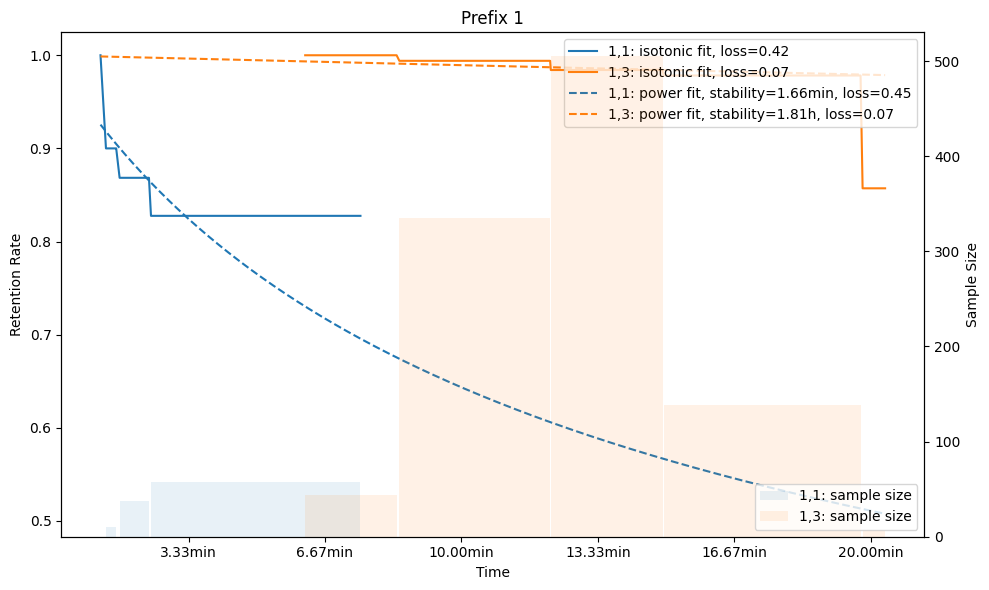

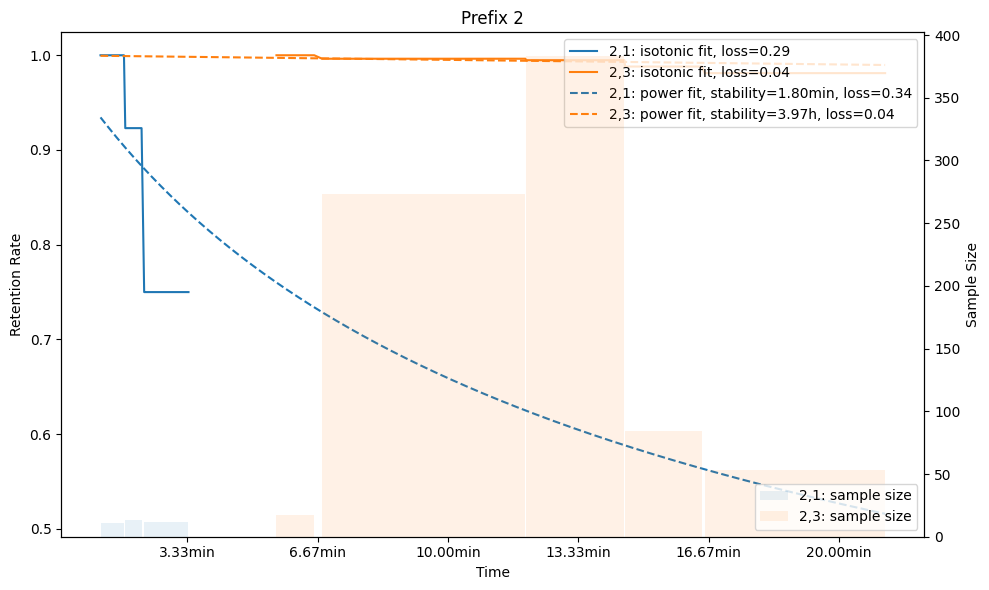

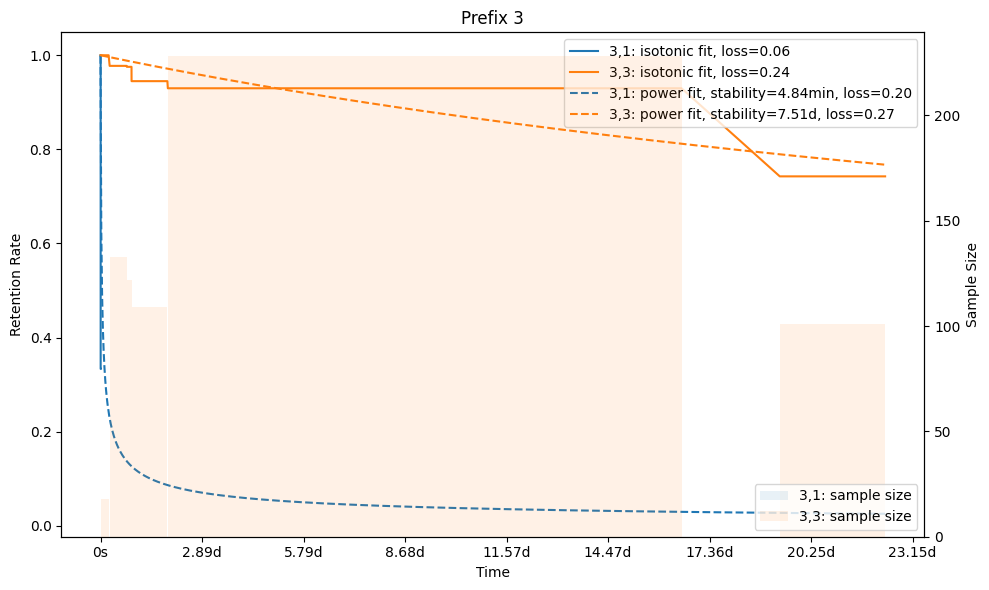

In [3]:
prefix_groups = {
    "1": ["1,1", "1,3"],
    "2": ["2,1", "2,3"],
    "3": ["3,1", "3,3"],
}

for prefix, r_history_group in prefix_groups.items():
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()

    min_delta_t = float("inf")
    max_delta_t = float("-inf")

    for i, r_history in enumerate(r_history_group):
        color = f"C{i}"
        data = df[df["r_history"] == r_history][["elapsed_seconds", "y"]]
        Q1 = data["elapsed_seconds"].quantile(0.25)
        Q3 = data["elapsed_seconds"].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        filtered_data = data[
            (data["elapsed_seconds"] >= lower_bound) & (data["elapsed_seconds"] <= upper_bound)
        ]
        x, y = filtered_data.sort_values(by="elapsed_seconds").values.T

        min_delta_t = min(min_delta_t, x.min())
        max_delta_t = max(max_delta_t, x.max())

        if all(y == 1):
            continue

        ir = IsotonicRegression(y_min=0, y_max=1, increasing=False)
        ir.fit(x, y)

        y_ir = ir.predict(x)
        loss_ir = log_loss(y, y_ir)

        s_seconds = fit_stability(x, y_ir, np.ones_like(x))
        s = (
            f"{s_seconds:.2f}s"
            if s_seconds < 60
            else (
                f"{s_seconds/60:.2f}min"
                if s_seconds < 3600
                else (
                    f"{s_seconds/3600:.2f}h"
                    if s_seconds < 86400
                    else f"{s_seconds/86400:.2f}d"
                )
            )
        )
        cnt = len(x)

        ax1.plot(
            x,
            y_ir,
            "-",
            color=color,
            label=f"{r_history}: isotonic fit, loss={loss_ir:.2f}",
        )

        unique_y_ir = np.unique(y_ir)
        segment_counts = []
        segment_x = []
        segment_widths = []
        for i in range(len(unique_y_ir)):
            mask = y_ir == unique_y_ir[i]
            segment_counts.append(np.sum(mask))
            segment_x.append(np.min(x[mask]))
            segment_widths.append(np.max(x[mask]) - np.min(x[mask]))

        ax2.bar(
            segment_x,
            segment_counts,
            alpha=0.1,
            width=segment_widths,
            color=color,
            label=f"{r_history}: sample size",
            align="edge",
        )

    x_power = np.linspace(min_delta_t, max_delta_t, 1000)
    for i, r_history in enumerate(r_history_group):
        color = f"C{i}"
        data = df[df["r_history"] == r_history][["elapsed_seconds", "y"]]
        Q1 = data["elapsed_seconds"].quantile(0.25)
        Q3 = data["elapsed_seconds"].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        filtered_data = data[
            (data["elapsed_seconds"] >= lower_bound) & (data["elapsed_seconds"] <= upper_bound)
        ]
        x, y = filtered_data.sort_values(by="elapsed_seconds").values.T

        if all(y == 1):
            continue

        ir = IsotonicRegression(y_min=0, y_max=1, increasing=False)
        ir.fit(x, y)
        y_ir = ir.predict(x)

        s_seconds = fit_stability(x, y_ir, np.ones_like(x))
        s = (
            f"{s_seconds:.2f}s"
            if s_seconds < 60
            else (
                f"{s_seconds/60:.2f}min"
                if s_seconds < 3600
                else (
                    f"{s_seconds/3600:.2f}h"
                    if s_seconds < 86400
                    else f"{s_seconds/86400:.2f}d"
                )
            )
        )
        y_pred = power_forgetting_curve(x_power, s_seconds)
        loss = log_loss(y, power_forgetting_curve(x, s_seconds))

        ax1.plot(
            x_power,
            y_pred,
            "--",
            color=color,
            label=f"{r_history}: power fit, stability={s}, loss={loss:.2f}",
        )

    ax1.set_title(f"Prefix {prefix}")
    ax1.legend(loc="upper right")
    ax2.legend(loc="lower right")

    def format_time(x, pos):
        if x < 60:
            return f"{x:.0f}s"
        elif x < 3600:
            return f"{x/60:.2f}min"
        elif x < 86400:
            return f"{x/3600:.2f}h"
        else:
            return f"{x/86400:.2f}d"

    ax1.xaxis.set_major_formatter(plt.FuncFormatter(format_time))
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Retention Rate")
    ax2.set_ylabel("Sample Size")

    plt.tight_layout()
    plt.show()